In [1]:
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import geopandas
import datetime as dt
# import geopy
import helper
# import matplotlib.lines as mlines

style.use('fivethirtyeight')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

#### Load Data

In [2]:
# Only going to be looking at Citi Bike data from March and April of 2021
citi = helper.get_all_citi_df(start_month=3, start_year=2021)


#### Add zipcode field

In [3]:
# Load previously processed stations and their corresponding zipcodes and check for
# station id's with no corresponding zipcodes
station_zipcode = pd.read_csv(r'station_zipcode.csv',
                   index_col=0,)
zipcode_dict = dict(zip(station_zipcode.station_id, station_zipcode.zipcode))
id_to_zipcode = helper.update_zip_code_dict(citi,zipcode_dict)

# mapping statin ID to zip code
citi["start_zipcode"] = citi["Start Station ID"].map(id_to_zipcode)
citi["end_zipcode"] = citi["End Station ID"].map(id_to_zipcode)

# save station to zip code mapping for future use if there were new zip codes added.
id_to_zipcode_df = pd.DataFrame(id_to_zipcode.items(), columns=['station_id', 'zipcode'])
id_to_zipcode_df.to_csv('station_zipcode.csv')

No new ZIP codes.


#### Keep only important features.

In [4]:
# Removing unessential columns
citi = citi[['Trip Duration', 'Start Time', 
               'Start Station Name', 'Start Station Latitude',
               'Start Station Longitude', 'End Station Name',
               'End Station Latitude', 'End Station Longitude', 
               'start_zipcode', 'end_zipcode']]
# Removing trips that are over an hour and half long.
trip_duration_extreme = citi["Trip Duration"].quantile(0.99)
citi = citi[(citi["Trip Duration"] < trip_duration_extreme)].reset_index(drop=True)

# Adding hour column.
citi['hour'] = citi['Start Time'].dt.hour

#### Looking only at NYC zip codes.

In [5]:
# NYC zip codes.
gnyc_zip = geopandas.read_file("nyc_zip_codes/ZIP_CODE_040114.shp")  
gnyc_zip = gnyc_zip.to_crs("EPSG:4326") # axis are now in lat/long format
nyc_zip_list = list(gnyc_zip.ZIPCODE)
# Removing all trips that go to New Jersey or random ferry islands.
citi = citi[citi['start_zipcode'].isin(nyc_zip_list)]
citi = citi[citi['end_zipcode'].isin(nyc_zip_list)]

#### Visualizing hourly bike increases/ decreases

In [6]:
# Find the net incrase/decrease at each station in each hour.
# find count of trips ending and starting at each station 
start_station_agg = citi.groupby(['hour','Start Station Name']).count()['start_zipcode'].sort_values().reset_index()
end_station_agg = citi.groupby(['hour','End Station Name']).count()['end_zipcode'].sort_values().reset_index()

station_count = pd.merge(start_station_agg, end_station_agg,  
                              how='inner', 
                              left_on=['Start Station Name','hour'], 
                              right_on = ['End Station Name','hour'])

station_count = station_count[['hour','Start Station Name',
                         'start_zipcode','end_zipcode']]
station_count.rename(columns={'Start Station Name':'station',
                           'start_zipcode':'leaving',
                           'end_zipcode':'arriving'},
                     inplace=True)

# count the net increase/decrease per day at that hour
station_count['net'] = station_count['arriving']-station_count['leaving']
num_days = len(citi['Start Time'].dt.normalize().unique())
station_count['net_day'] = station_count['net']/num_days


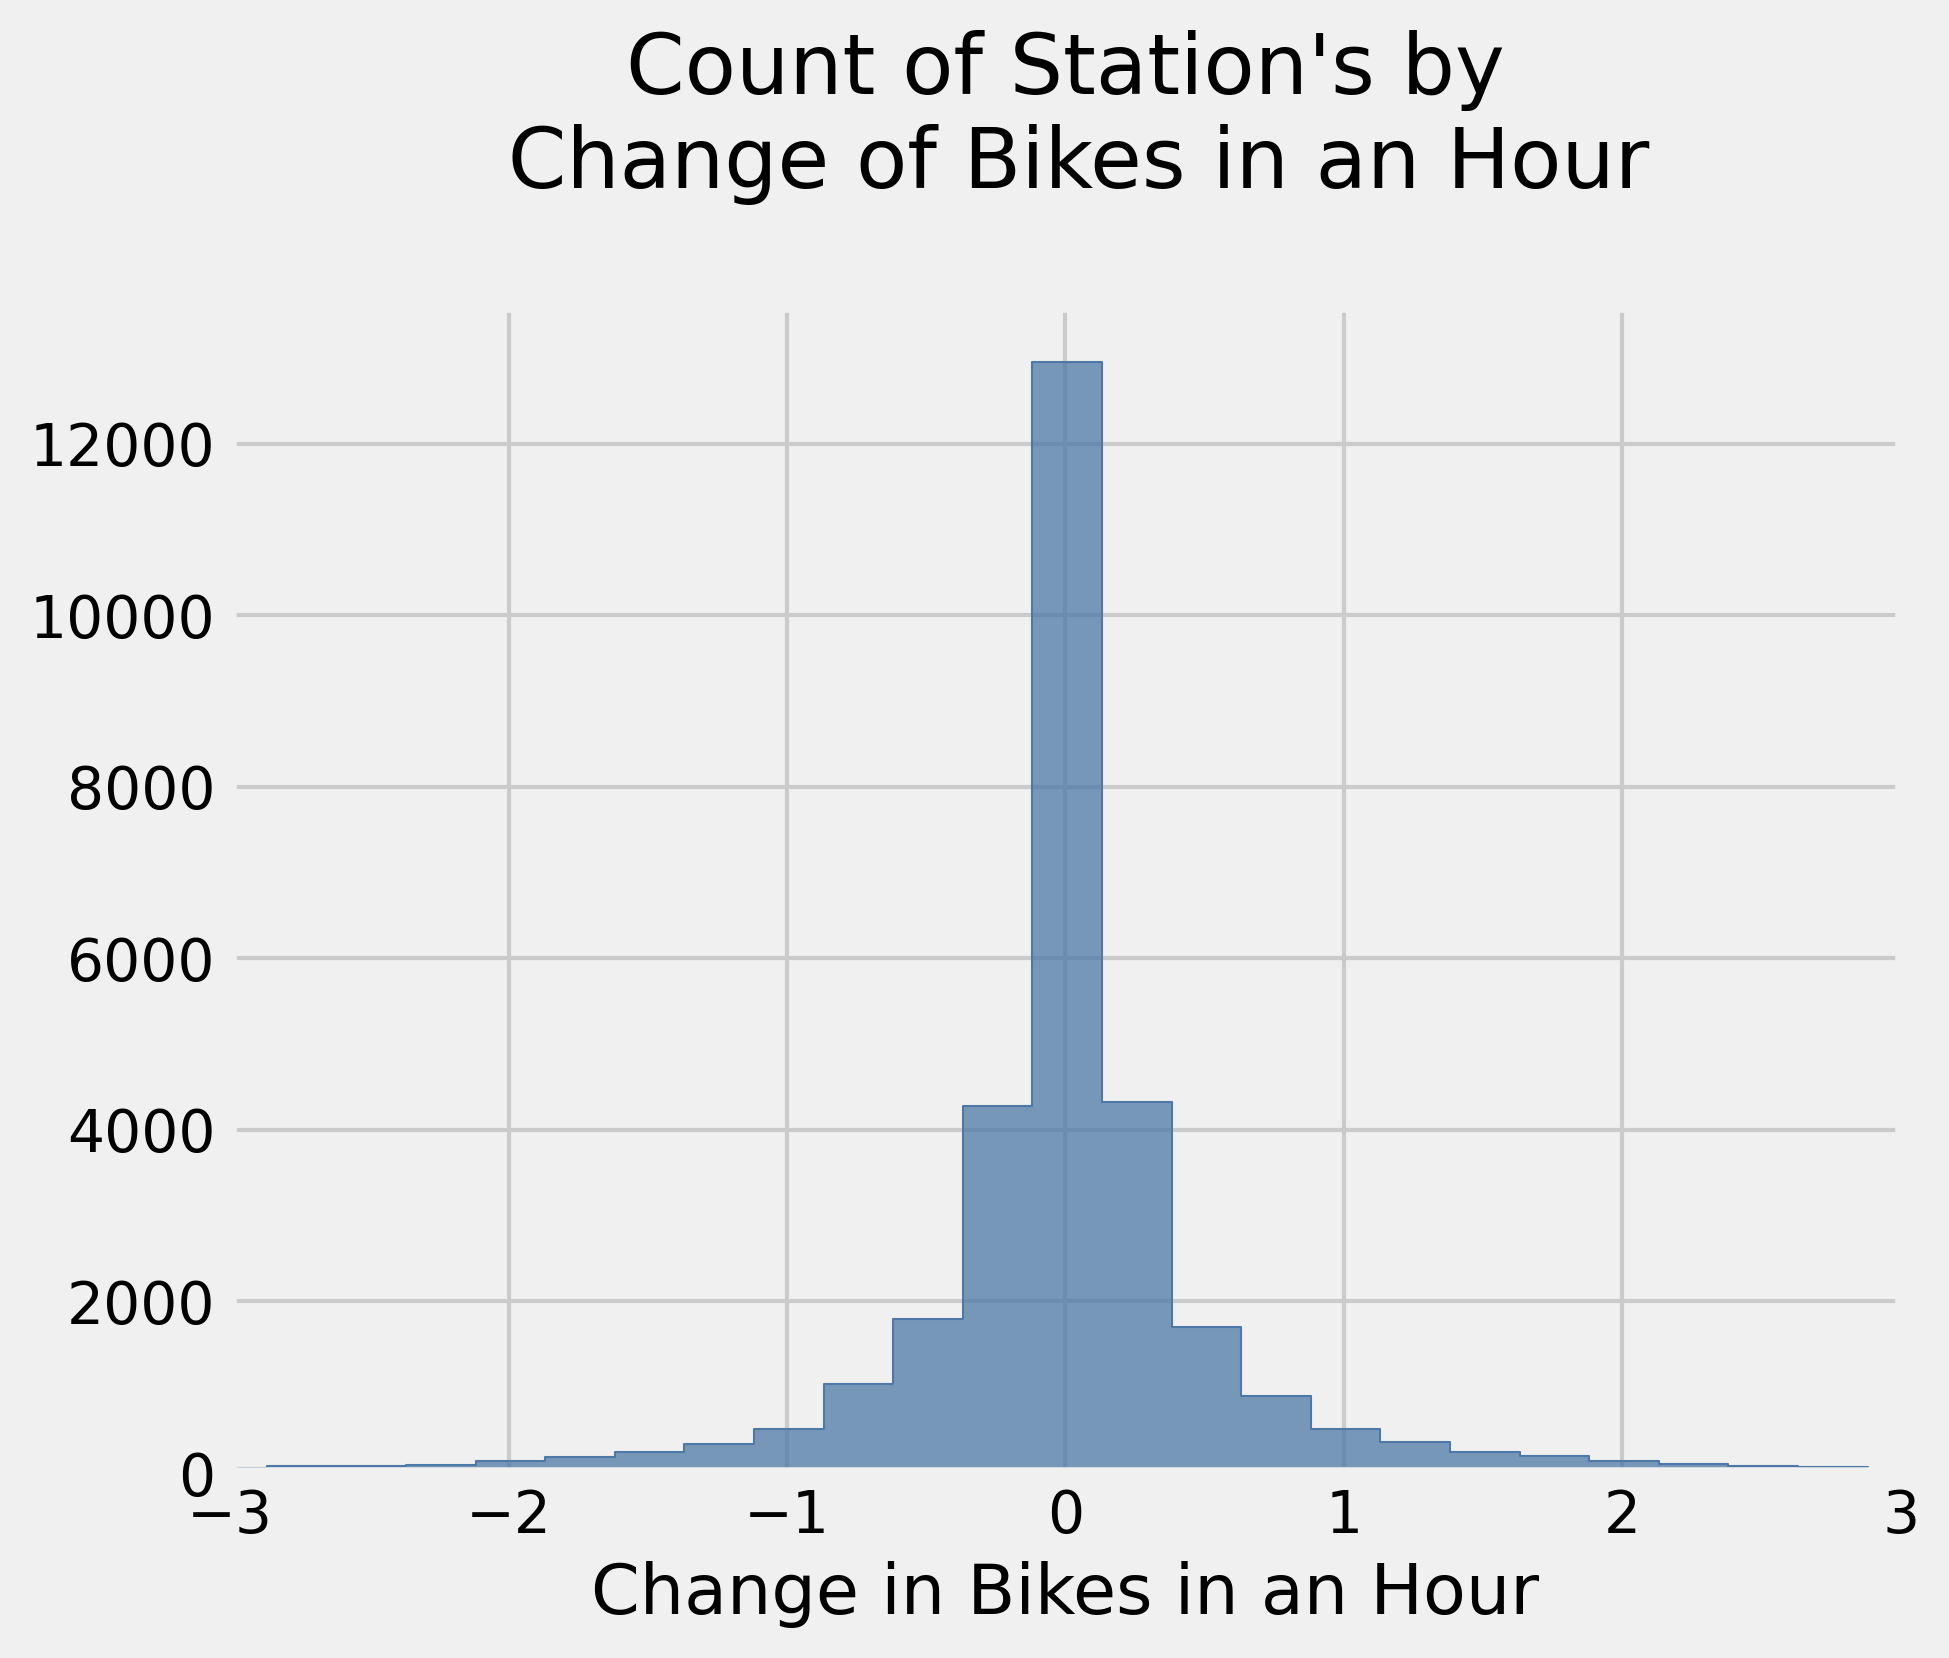

In [7]:
# almost all the time the stations are in balance
# graph
g = sns.histplot(x='net_day', data=station_count,binwidth=.25, 
                 element="step", color= '#4e79a7')
# labels
g.set(ylabel='', xlabel='Change in Bikes in an Hour',
      title="Count of Station's by\n Change of Bikes in an Hour\n")

# x limit. 
plt.xlim(-3, 3)
plt.show()

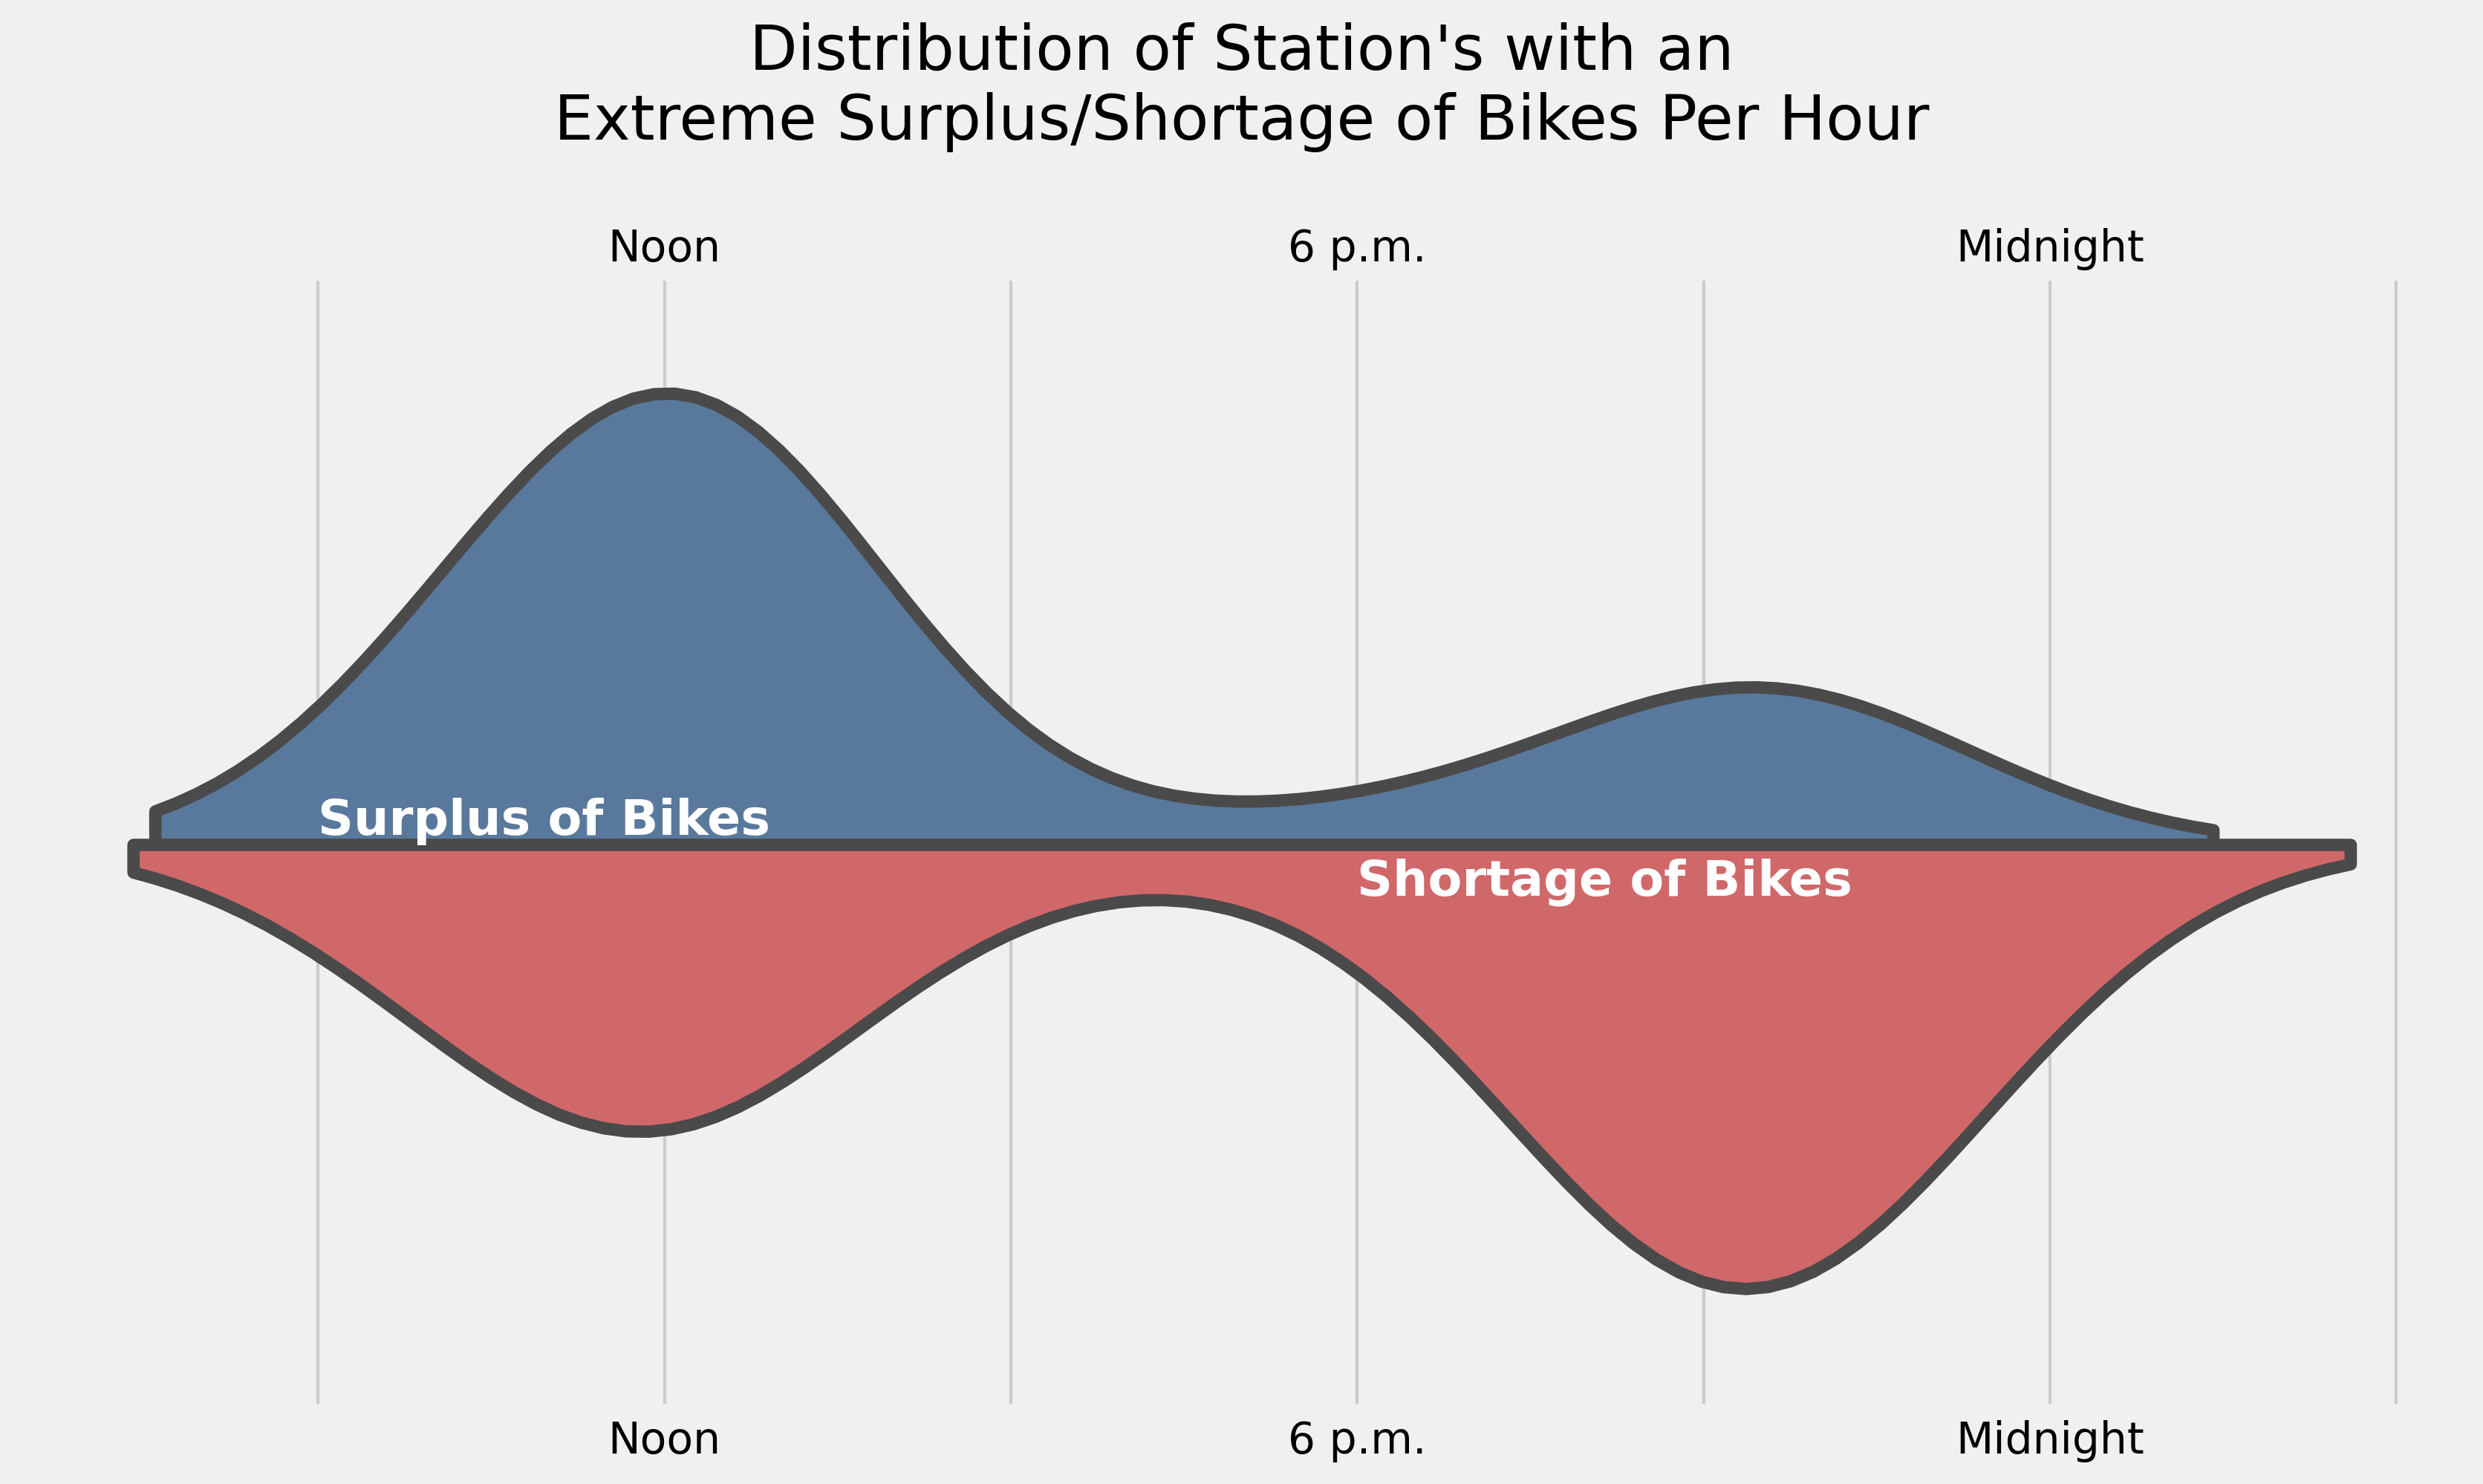

In [8]:
# looking only at when a station has a big surplus or shortage of bikes
# data prep to graph
station_crisis = station_count[~(abs(station_count['net_day'])<3)].reset_index(drop=True)
station_crisis['surplus'] = (station_crisis['net_day']>0).astype(int)
station_crisis['dummy'] = 1
station_crisis.loc[station_crisis["hour"] == 0, "hour"] = 24
station_crisis.loc[station_crisis["hour"] == 1, "hour"] = 25

color = ['#4e79a7',
         '#e15759']
# graph
g = sns.catplot(data = station_crisis,kind='violin',
                   x='hour', y = 'dummy',hue = 'surplus',
                   scale='count',
                   cut = True,orient='h',
                   split=True,hue_order = [1,0],
                   palette = color,inner=None,legend=False,
                height=6,aspect=2
                  )

# Labels
plt.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
g.set(xticks=[9,12,15,18,21,24,27])
g.set(xticklabels=['','Noon','',
                   '6 p.m.','','Midnight',''])
g.set(yticklabels=[])
# g.set(xticklabels=[])
plt.text(x = 9, y = -0.009,
               s = "Surplus of Bikes",
              fontsize=16,color='white',weight='bold')
plt.text(x = 18, y = 0.045,
               s = "Shortage of Bikes",
              fontsize=16,color='white',weight='bold')

# title
g.set(xlabel='', ylabel='',title="Distribution of Station's with an\nExtreme Surplus/Shortage of Bikes Per Hour\n")
plt.show()